# Multi-view video datasets and Label3D data structure

In this notebook, we will demonstrate the basic data structures in Label3D annotations and how they can be visualized in the corresponding multi-view video recordings.

In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import yaml
import imageio
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt

from dannce.engine.data.io import load_camera_params, load_labels, load_camnames
from dannce.engine.utils.projection import distortPoints, project_to_2d
from dannce.engine.skeletons.utils import load_body_profile

%matplotlib inline

## DANNCE data organization

DANNCE/s-DANNCE typically requires annotations acquired from multiple experiments with multi-view camera captures for best pose tracking performance. As an example, in `demo/2021_07_06_M3_M6`, each experiment is expected to contain the following for the minimum:
```
    videos/
        Camera1/
            0.mp4
        ...
        ...
        Camera6/
            0.mp4
    some-labeling-file-exported-from-Label3D-DANNCE.mat
    io.yaml
```

Let's unpack these componenets in more details:
- `videos`, by default, contains the multi-view video recordings stored in sub-directories named by the corresponding camera names (`camnames`). Each video file must be named as `{start-frame-corresponding-to-this-video}.mp4` so that when one experiment is split into multiple videos, they can be correctly loaded and matched.
- The `**_Label3D_dannce.mat` file should be what you export from Label3D after multi-view labeling. For sanity check, it should contain four entries, with `N=6` cameras in the setup,
    - `camnames`: 1xN cell
        - [Camera1, Camera2, Camera3, Camera4, Camera5, Camera6]
    - `labelData`: Nx1 cell -> hand-labeled annotations in `M` frames
        - `data_2d` [M, num_keypointsx2]
        - `data_3d` [M, num_keypointsx3]
        - `data_frame` [M, 1]
        - `data_sampleID` [1, M] UNIQUE data identifiers
    - `params`: Nx1 cell -> camera extrinsics and intrinsics parameters
        - K, RDistort, TDistort, r, t
    - `sync`: Nx1 cell -> synchronization information across views
        - entries same as labelData, but for all frames in the recordings (data_2d & data_3d only placeholders).
    
    Notice: Label3D can be used for annotating both animal centroids (COM) and 3D poses (DANNCE). Please make sure to distinguish. 

- `io.yaml` contains configurations for what experiments to be included for training (there could be multiple ones).
    - For training COM models, the training set is specified as combination of COM labels from these two experiments:
        ```
        com_exp:
            - label3d_file: '../2021_07_06_M3_M6/ANNOT_COM_BR_dannce.mat'
            - label3d_file: '../2021_07_07_M5_M1/ANNOT_COM_BR_dannce.mat'
        ```
    - For training DANNCE/s-DANNCE models, the 3D pose annotation files need to be paired with the COM prediction files:
        ```
        exp:
            - label3d_file: '../2021_07_06_M3_M6/ANNOT_Label3D_B_dannce.mat'
                com_file: '../2021_07_06_M3_M6/COM/predict01/instance0com3d.mat'
            - label3d_file: '../2021_07_06_M3_M6/ANNOT_Label3D_R_dannce.mat'
                com_file: '../2021_07_06_M3_M6/COM/predict01/instance1com3d.mat'
        ```
        where we separately annotated for each animal with the same social recording.

### Visualize Label3D annotations in multi-view recordings

We now visualize what's inside each `exp` entry.

In [7]:
IO_FILE = "/home/tianqingli/dl-projects/sdannce/demo/2021_07_06_M3_M6/io.yaml"
dataroot = os.path.dirname(IO_FILE)
io_info = yaml.safe_load(open(IO_FILE, "r"))
exps = io_info["exp"]
for expid, exp in enumerate(exps):
    print(f"Experiment {expid}:")
    print("  ", " ".join([f"{k}: {v}" for k, v in exp.items()]))

Experiment 0:
   label3d_file: ../2021_07_06_M3_M6/ANNOT_Label3D_B_dannce.mat com_file: ../2021_07_06_M3_M6/COM/predict01/instance0com3d.mat
Experiment 1:
   label3d_file: ../2021_07_06_M3_M6/ANNOT_Label3D_R_dannce.mat com_file: ../2021_07_06_M3_M6/COM/predict01/instance1com3d.mat
Experiment 2:
   label3d_file: ../2021_07_07_M5_M1/ANNOT_Label3D_B_dannce.mat com_file: ../2021_07_07_M5_M1/COM/predict01/instance0com3d.mat
Experiment 3:
   label3d_file: ../2021_07_07_M5_M1/ANNOT_Label3D_R_dannce.mat com_file: ../2021_07_07_M5_M1/COM/predict01/instance0com3d.mat


Label3D file /home/tianqingli/dl-projects/sdannce/demo/2021_07_06_M3_M6/../2021_07_06_M3_M6/ANNOT_Label3D_R_dannce.mat contains 44 samples


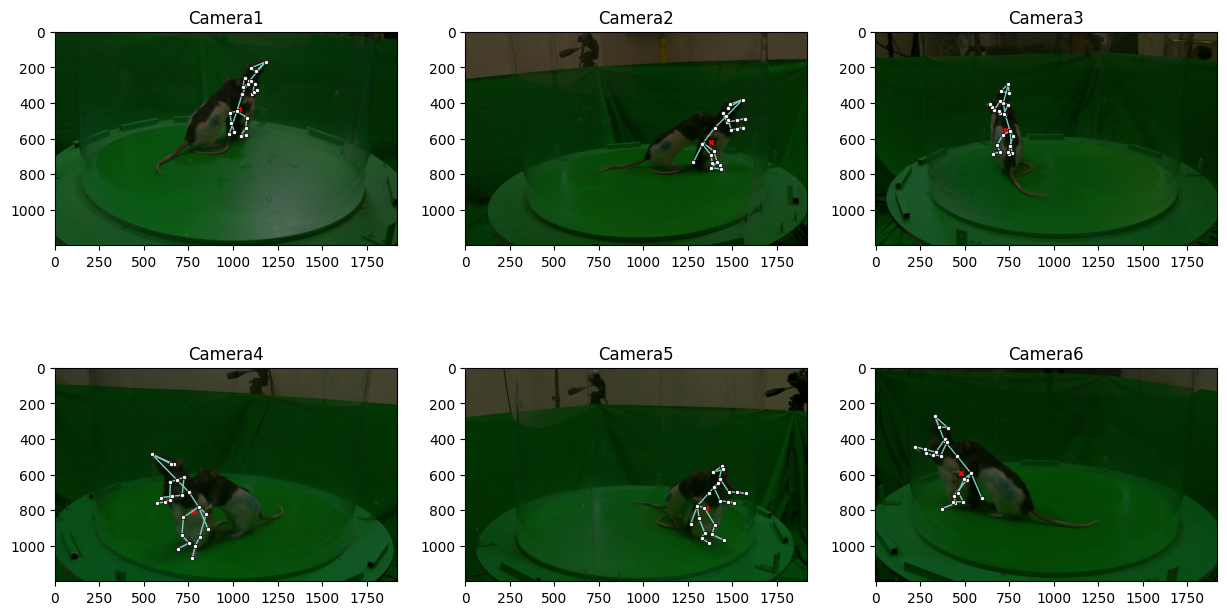

In [81]:
def project_3d_points_to_2d(pts: np.ndarray, camera_params: dict) -> np.ndarray:
    """Project 3D points to a specific camera view

    Args:
        pts (_type_): 3D points [N, 3]
        camera_params (_type_): _description_

    Returns:
        np.ndarray: 2D points [N, 2]
    """
    projpts = project_to_2d(
        pts, camera_params["K"], camera_params["r"], camera_params["t"]
    )[:, :2]
    projpts = distortPoints(
        projpts,
        camera_params["K"],
        np.squeeze(camera_params["RDistort"]),
        np.squeeze(camera_params["TDistort"]),
    )
    return projpts.T


def visualize_experiment_files(exp: dict, n_cols: int = 3):
    label3d_file, com_file = exp["label3d_file"], exp["com_file"]
    # add to absolute dataroot
    label3d_file = os.path.join(dataroot, label3d_file)
    com_file = os.path.join(dataroot, com_file)
    
    assert os.path.exists(label3d_file), f"label3d_file {label3d_file} does not exist"
    assert os.path.exists(com_file), f"com_file {com_file} does not exist"
    
    viddir = os.path.dirname(label3d_file) + "/videos"
    assert os.path.exists(viddir), f"viddir {viddir} does not exist"
    
    # load label3d labels
    labels = load_labels(label3d_file)
    camera_params = load_camera_params(label3d_file)
    camnames = load_camnames(label3d_file)
    camera_params = {f"Camera{i+1}": params for i, params in enumerate(camera_params)}
    
    # data_sampleIDs are UNIQUE identifiers for synchronizing multi-view data streams
    # data_frames, can vary across views due to acqusition delays
    # both are 0-indexed
    data_sampleID = np.squeeze(labels[0]["data_sampleID"])
    print(f"Label3D file {label3d_file} contains {len(data_sampleID)} samples")
    
    com_data = sio.loadmat(com_file)
    labeled_indices = np.array([np.where(com_data["sampleID"][0] == sample) for sample in data_sampleID])
    com3d = com_data["com"][labeled_indices]
    pose3d = labels[0]["data_3d"]
    
    # load video readers
    vidreaders = {
        camname: imageio.get_reader(os.path.join(viddir, camname, "0.mp4"))
        for camname in camnames
    }

    # visualize a random sample
    vis_idx = np.random.randint(len(data_sampleID))
    
    n_rows = len(camnames) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten()
    skeleton = load_body_profile("rat23")
    
    for camidx, camname in enumerate(camnames):
        ax = axes[camidx]
        ax.set_title(camname)
        
        # retrieve the corresponding frame
        data_frames = np.squeeze(labels[camidx]["data_frame"])
        frame_idx = data_frames[vis_idx]
        
        image = vidreaders[camname].get_data(frame_idx)
        ax.imshow(image)
        
        # visualize 3d COMs
        _com3d = com3d[vis_idx].reshape((-1, 3))
        com2d = project_3d_points_to_2d(_com3d, camera_params[camname])
        ax.scatter(*com2d.T, s=10, c="r", label="COM-GT", marker="x")
        
        # visualize 3d pose
        _pose3d = pose3d[vis_idx].reshape((-1, 3))
        pose2d = project_3d_points_to_2d(_pose3d, camera_params[camname])

        for limb in skeleton["limbs"]:
            ax.plot(pose2d[limb, 0], pose2d[limb, 1],
                    c="#7fcdbb", linewidth=1, label="Pose-GT",
                    marker="o", markersize=3, markerfacecolor="w", markeredgewidth=0.5, markeredgecolor="k",
            )
    return camera_params, pose3d, com3d


#####################################
camera_params, pose3d, com3d = visualize_experiment_files(exps[1])